# snnTorch - Tutorial 4
### By Jason K. Eshraghian

Note: explanation is yet to be added. For now, only code is updated to show how to automatically implement TBPTT.

# Truncated Backpropagation through time
In this tutorial, we'll use a convolutional neural network (CNN) to classify the MNIST dataset.
We will use the truncated backpropagation through time (BPTT) algorithm to do so. This tutorial is largely the same as tutorial 2, just with a different network architecture to show how to integrate convolutions with snnTorch.

If running in Google Colab:
* Ensure you are connected to GPU by checking Runtime > Change runtime type > Hardware accelerator: GPU
* Next, install the Test PyPi distribution of snnTorch by clicking into the following cell and pressing `Shift+Enter`.

In [2]:
# Install the test PyPi Distribution of snntorch
!pip install -i https://test.pypi.org/simple/ snntorch

Looking in indexes: https://test.pypi.org/simple/


## 1. Setting up the Static MNIST Dataset
### 1.1. Import packages and setup environment

In [3]:
import snntorch as snn
from snntorch import backprop as bp
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import itertools
import matplotlib.pyplot as plt

### 1.2 Define network and SNN parameters
We will use a 2conv-2MaxPool-FCN architecture for a sequence of 25 time steps.

* `alpha` is the decay rate of the synaptic current of a neuron
* `beta` is the decay rate of the membrane potential of a neuron

In [4]:
# Network Architecture
num_inputs = 28*28
num_hidden = 1000
num_outputs = 10

# Training Parameters
batch_size=128
data_path='/data/mnist'

# Temporal Dynamics
num_steps = 25
time_step = 1e-3
tau_mem = 4e-3
tau_syn = 3e-3
alpha = float(np.exp(-time_step/tau_syn))
beta = float(np.exp(-time_step/tau_mem))

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

### 1.3 Download MNIST Dataset
To see how to construct a validation set, refer to Tutorial 1.

In [5]:
# Define a transform
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

### 1.4 Create DataLoaders

In [6]:
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

## 2. Define Network
snnTorch contains a series of neuron models and related functions to ease the training process.
Neurons are treated as activations with recurrent connections, and integrate smoothly with PyTorch's pre-existing layer functions.
* `snntorch.Stein` is a simple Leaky Integrate and Fire (LIF) neuron. Specifically, it uses Stein's model which assumes instantaneous rise times for synaptic current and membrane potential.
* `snntorch.FastSigmoidSurrogate` defines separate forward and backward functions. The forward function is a Heaviside step function for spike generation. The backward function is the derivative of a fast sigmoid function, to ensure continuous differentiability.
FSS is mostly derived from:

>Neftci, E. O., Mostafa, H., and Zenke, F. (2019) Surrogate Gradient Learning in Spiking Neural Networks. https://arxiv.org/abs/1901/09948

There are a few other surrogate gradient functions included.
`snn.slope` is a variable that defines the slope of the backward surrogate.
TO-DO: Include visualisation.


Now we can define our spiking neural network (SNN).
If you have already worked through Tutorial 2, you may wish to skip ahead.

The init_hidden argument will initialize the hidden states & spike outputs as instance variables.
Although the forward method looks messier with the calls to these instance variables, it eliminates the need to detach all the variables from the computational graph manually.

In [7]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()

    # initialize layers
        snn.LIF.clear_instances() # boilerplate
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Stein(alpha=alpha, beta=beta, num_inputs=num_hidden, batch_size=batch_size, init_hidden=True)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Stein(alpha=alpha, beta=beta, num_inputs=num_outputs, batch_size=batch_size, init_hidden=True)


    def forward(self, x):
        cur1 = self.fc1(x)
        self.lif1.spk1, self.lif1.syn1, self.lif1.mem1 = self.lif1(cur1, self.lif1.syn, self.lif1.mem)
        cur2 = self.fc2(self.lif1.spk)
        self.lif2.spk, self.lif2.syn, self.lif2.mem = self.lif2(cur2, self.lif2.syn, self.lif2.mem)

        return self.lif2.spk, self.lif2.mem

net = Net().to(device)

## 3. Training
Time for training! Let's define our train and test functions.

In [8]:
def train(net, device, train_loader, optimizer, criterion, epoch):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        loss = bp.TBPTT(net, data, target, num_steps, batch_size, optimizer, criterion, K=K)
        # loss = bp.BPTT(net, data, target, num_steps, batch_size, optimizer, criterion)

        if batch_idx % 20 == 0:
            print(f"Train Epoch: {epoch} [{batch_idx*len(data)}/{len(train_loader.dataset)}], "
                  f"Loss: {loss.item()}")
    loss_hist.append(loss.item())  # only recording at the end of each epoch


def test(net, device, test_loader, criterion):
    net.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)

            spk2_rec = []
            snn.Stein.zeros_hidden()  # reset hidden states to 0
            if data.size()[0] == batch_size:
                for step in range(num_steps):
                    spk2, mem2 = net(data.view(batch_size, -1))
                    spk2_rec.append(spk2)

                # Test Loss where batch=128; only calc on final time step
                # log_p_ytest = log_softmax_fn(mem2)
                test_loss += criterion(mem2, target)
                # Test Acc where batch=128
                _, idx = torch.stack(spk2_rec, dim=0).sum(dim=0).max(1)  # predicted indexes
                correct += sum((target == idx).cpu().numpy())
                # print(correct)

            else:  # Handle drop_last = False
                temp_data = torch.zeros((batch_size, *(data[0].size())), dtype=dtype, device=device)  # pad out temp_data now
                temp_data[:(data.size()[0])] = data

                for step in range(num_steps):
                    spk2, mem2 = net(temp_data.view(batch_size, -1))
                    spk2_rec.append(spk2)

                # Test set loss - only calc on the final time-step
                # log_p_ytest = log_softmax_fn(mem2[:data.size()[0]])
                test_loss += criterion(mem2[:data.size()[0]], target)
                # Test Acc where batch=128
                _, idx = torch.stack(spk2_rec, dim=0).sum(dim=0).max(1)  # predicted indexes
                correct += sum((target == idx[:data.size()[0]]).cpu().numpy())

        test_loss_hist.append(test_loss.item())
        test_acc = correct / len(test_loader.dataset)
        print(f"\nTest set: Average loss: {(test_loss/(len(test_loader.dataset)/batch_size))}, Accuracy: [{correct}/{len(test_loader.dataset)}] ({(correct/len(test_loader.dataset))})\n"
              f"=====================\n")

        return test_loss, test_acc, spk2_rec

### 3.1 Optimizer & Loss
* *Output Activation*: We'll apply the softmax function to the membrane potentials of the output layer, rather than the spikes.
* *Loss*: This will then be used to calculate the negative log-likelihood loss.
By encouraging the membrane of the correct neuron class to reach the threshold, we expect that neuron will fire more frequently.
The loss could be applied to the spike count as well, but the membrane is  continuous whereas spike count is discrete.
* *Optimizer*: The Adam optimizer is used for weight updates.
* *Accuracy*: Accuracy is measured by counting the spikes of the output neurons. The neuron that fires the most frequently will be our predicted class.


### 3.2 Training Loop
Now just sit back, relax, and wait for convergence.

In [9]:
no_trials = 1
# lr_values = [1e-3, 5e-4, 1e-4] # these values are good
lr_values = [1e-4]
batch_size = 128
data_path = '/data/mnist'
# subset = 50  # can remove this line in Colab
num_steps = 25
epochs = 1
betas = (0.9, 0.999)
K = 25  # number of time steps to accumulate over -- right now I'm using BPTT anyway so this is ignored
SAVE_GOOGLE_COLAB = False
dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0,), (1,))
])
mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)
# mnist_train = data_subset(mnist_train, subset)  # reduce dataset by x100 - can remove this line in Colab
# mnist_test = data_subset(mnist_test, subset)
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=False)

# Adam
# df = pd.DataFrame(columns=['lr', 'epoch', 'test_set_loss', 'test_set_accuracy'])
for i in range(no_trials):
    for lr in lr_values:
        net = Net().to(device)
        optimizer = torch.optim.Adam(net.parameters(), lr=lr, betas=betas)
        # log_softmax_fn = nn.LogSoftmax(dim=-1)
        criterion = nn.CrossEntropyLoss() # note: CrossEntropy dims must be B x num_classes. Can increase dimensionality, read docs.

        loss_hist = []
        test_loss_hist = []
        print(f"========Trial: {i}, Learning Rate: {lr}")
        for epoch in range(epochs):
            train(net, device, train_loader, optimizer, criterion, epoch)
            test_loss, test_acc, _ = test(net, device, test_loader, criterion)

            # df = df.append(
            #     {'trial': i, 'lr': lr, 'epoch': epoch, 'test_set_loss': test_loss.item(),
            #      'test_set_accuracy': test_acc}, ignore_index=True)
            # df.to_csv('Adam_BPTT2.csv', index=False)
            # if SAVE_GOOGLE_COLAB:
            #     shutil.copy("Adam_BPTT.csv", "/content/Adam_BPTT.csv")


loss_hist_true_grad = loss_hist
test_loss_hist_true_grad = test_loss_hist

========Trial: 0, Learning Rate: 0.0001
Train Epoch: 0 [0/60000], Loss: 87.99430084228516
Train Epoch: 0 [2560/60000], Loss: 31.979496002197266
Train Epoch: 0 [5120/60000], Loss: 20.729297637939453
Train Epoch: 0 [7680/60000], Loss: 21.22612762451172
Train Epoch: 0 [10240/60000], Loss: 17.037744522094727
Train Epoch: 0 [12800/60000], Loss: 16.702619552612305
Train Epoch: 0 [15360/60000], Loss: 15.043231010437012
Train Epoch: 0 [17920/60000], Loss: 15.852062225341797
Train Epoch: 0 [20480/60000], Loss: 18.419878005981445
Train Epoch: 0 [23040/60000], Loss: 15.934926986694336
Train Epoch: 0 [25600/60000], Loss: 14.167062759399414
Train Epoch: 0 [28160/60000], Loss: 13.726014137268066


KeyboardInterrupt: 

## 4. Results
### 4.1 Plot Training/Test Loss

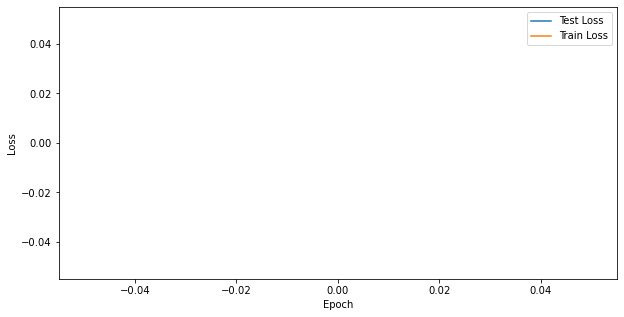

In [22]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.legend(["Test Loss", "Train Loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

That's it for static MNIST! Now let's use ``spikeplot`` to watch in real time how the output layer responds to a few different samples.

In [10]:
from snntorch import utils
# Let's just test on one single batch
mnist_anim = datasets.MNIST(data_path, train=False, download=True, transform=transform)
mnist_anim = utils.data_subset(mnist_anim, subset=78)
anim_loader = DataLoader(mnist_anim, batch_size=batch_size, shuffle=True, drop_last=False)

# Pass anim_loader into test
_, _, spk_rec = test(net, device, anim_loader, criterion)


Test set: Average loss: 0.15009622275829315, Accuracy: [123/128] (0.9609375)



In [11]:
print(f"Data Size: {anim_loader.dataset[0][0].size()}")
print(f"Target: {anim_loader.dataset[22][1]}")

Data Size: torch.Size([1, 28, 28])
Target: 6


In [12]:
# spk_rec is a T x B x N_outputs tensor
# but we only want a single sample, so T x N tensor is input to snnboard
torch.stack(spk_rec, dim=0)[:, 0, :].size()

torch.Size([25, 10])

In [13]:
spk_results = torch.stack(spk_rec, dim=0)[:, 22, :].to('cpu')
print(f"Total number of spikes at t=T for a single sample:\n {spk_results.sum(dim=0)}")

Total number of spikes at t=T for a single sample:
 tensor([0., 0., 0., 0., 0., 0., 8., 0., 0., 0.])


Target: 6


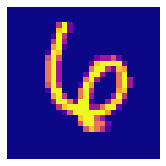

In [14]:
print(f"Target: {anim_loader.dataset[22][1]}")
plt.figure(facecolor="w")
plt.subplot(1,2,1)
plt.imshow(anim_loader.dataset[22][0].reshape((28,-1)).cpu(), cmap='plasma')
plt.axis('off')
plt.show()

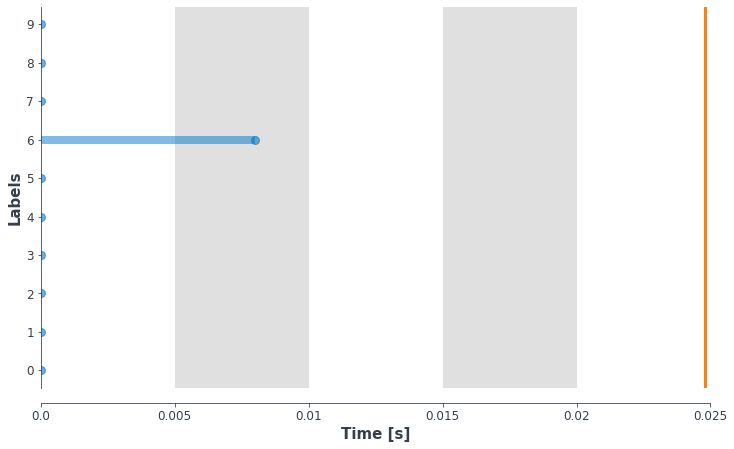

In [18]:
import snntorch.spikeplot as sp
from IPython.display import HTML

fig, ax = plt.subplots(facecolor='w', figsize=(12, 7))
labels=['0', '1', '2', '3', '4', '5', '6', '7', '8','9']

# animation
anim = sp.spike_count(spk_results, fig, ax, labels, animate=True, interpolate=5, num_steps = num_steps, time_step=1e-3)
HTML(anim.to_html5_video())
# anim.save("spike_bar.gif")

# final count
# sp.spike_count(spk_results, fig, ax, labels, interpolate=5, num_steps = num_steps, time_step=1e-3)
# plt.show()